### 문자 레벨 기계 번역 구현

#### 병렬 데이터 전처리
* 병렬 데이터: 쌍이 되는 데이터, 길이는 같지 않음

In [1]:
import pandas as pd
import tensorflow as tf
import urllib3
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
lines = pd.read_csv('fra.txt', names=['src', 'tar', 'lic'], sep='\t')
del lines['lic']
print('전체 샘플의 개수 :',len(lines))

전체 샘플의 개수 : 227815


In [7]:
lines.iloc[:10]

,src,tar
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !
5,Hi.,Salut.
6,Run!,Cours !
7,Run!,Courez !
8,Run!,Prenez vos jambes à vos cous !
9,Run!,File !


60000개의 샘플만 이용해서 기계번역 구축

In [10]:
lines = lines.iloc[0:60000] # 6만개만 저장
lines.sample(10)

,src,tar
6453,Tom felt bad.,Tom s'est senti mal.
55826,He's gone into hiding.,Il se planque.
31555,You're very brave.,Vous êtes très courageuses.
5091,I admire you.,Je vous admire.
48666,I live next to a dam.,Je vis à côté d'un barrage.
7806,I had a dream.,J'ai rêvé.
7722,I don't dream.,Je ne rêve pas.
4998,He is a poet.,C'est un poète.
25096,Any paper will do.,N’importe quel papier conviendra parfaitement.
58140,I've already paid you.,Je t'ai déjà payée.


시작 심볼 \t와 종료 심볼 \n 추가 (보통은 \<sos\>, \<eos\> 사용)

In [11]:
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')
lines.sample(10)

C:\Users\yejin.hwang\AppData\Local\Programs\Python\Python37\py37\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,src,tar
13909,You can't lose.,\t Vous ne pouvez pas perdre. \n
50467,Let's not be enemies.,\t Ne soyons pas ennemis. \n
41970,Ideas are important.,\t Les idées sont importantes. \n
40860,I know what's wrong.,\t Je sais ce qui ne va pas. \n
40877,I know you're a spy.,\t Je sais que vous êtes un espion. \n
30421,We split the bill.,\t On a partagé l'addition. \n
38464,You're an idealist.,\t Vous êtes un idéaliste. \n
51288,That was really hard.,\t Ça a été vraiment difficile. \n
22643,That isn't funny.,\t Ce n'est pas marrant. \n
24768,You'll regret it.,\t Vous le regretterez. \n


문자 집합 생성

In [12]:
# 문자 집합 구축
src_vocab = set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 문자씩 읽음
        src_vocab.add(char)

tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

In [13]:
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print('source 문장의 char 집합 :',src_vocab_size)
print('target 문장의 char 집합 :',tar_vocab_size)

source 문장의 char 집합 : 80
target 문장의 char 집합 : 104


In [14]:
src_vocab

{' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'é',
 'ï',
 '’',
 '€'}

In [15]:
tar_vocab

{'\t',
 '\n',
 ' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '«',
 '»',
 'À',
 'Ç',
 'É',
 'Ê',
 'Ô',
 'à',
 'â',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'î',
 'ï',
 'ô',
 'ù',
 'û',
 'œ',
 '\u2009',
 '‘',
 '’',
 '\u202f',
 '‽'}

In [16]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x']


각 문자에 인덱스 부여

In [17]:
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, 'ï': 77, '’': 78, '€': 79}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 3

정수 인코딩

In [29]:
# 정수 인코딩 - 영어(인코더의 입력값)
encoder_input = []

# 1개의 문장
for line in lines.src:
    encoded_line = []
    # 각 줄에서 1개의 char
    for char in line:
        # 각 char을 정수로 변환
        encoded_line.append(src_to_index[char])
    encoder_input.append(encoded_line)
print('source 문장의 정수 인코딩 :',encoder_input[:5])

source 문장의 정수 인코딩 : [[30, 64, 10], [30, 64, 10], [30, 64, 10], [30, 64, 10], [31, 58, 10]]


In [30]:
# 정수 인코딩 - 프랑스어(디코더의 입력값)
decoder_input = []

# 1개의 문장
for line in lines.tar:
    decoded_line = []
    # 각 줄에서 1개의 char
    for char in line:
        # 각 char을 정수로 변환
        decoded_line.append(tar_to_index[char])
    decoder_input.append(decoded_line)
print('source 문장의 정수 인코딩 :',decoder_input[:5])

source 문장의 정수 인코딩 : [[1, 3, 48, 52, 3, 4, 3, 2], [1, 3, 39, 52, 69, 54, 59, 56, 14, 3, 2], [1, 3, 31, 65, 3, 69, 66, 72, 71, 56, 3, 4, 3, 2], [1, 3, 28, 66, 72, 58, 56, 3, 4, 3, 2], [1, 3, 45, 52, 63, 72, 71, 3, 4, 3, 2]]


디코더의 예측값과 비교하기 위한 실제 값이 필요함 (밑의 그림에서 위의 단어들) -> 시작 심볼은 필요가 없으므로 제거
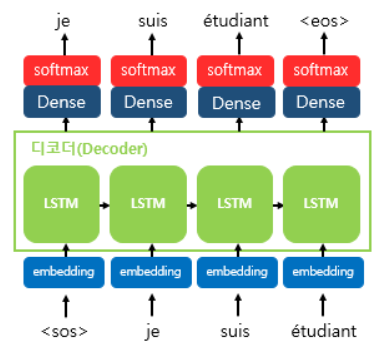

In [31]:
decoder_target = []
for line in lines.tar:
    timestep = 0
    encoded_line = []
    for char in line:
        if timestep > 0:
            encoded_line.append(tar_to_index[char])
        timestep = timestep + 1
    decoder_target.append(encoded_line)
print('target 문장 레이블의 정수 인코딩 :',decoder_target[:5])

target 문장 레이블의 정수 인코딩 : [[3, 48, 52, 3, 4, 3, 2], [3, 39, 52, 69, 54, 59, 56, 14, 3, 2], [3, 31, 65, 3, 69, 66, 72, 71, 56, 3, 4, 3, 2], [3, 28, 66, 72, 58, 56, 3, 4, 3, 2], [3, 45, 52, 63, 72, 71, 3, 4, 3, 2]]


In [32]:
# 가장 긴 샘플 길이 확인
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

source 문장의 최대 길이 : 22
target 문장의 최대 길이 : 76


padding          
병렬 데이터의 길이가 동일할 필요 x     
-> 영어와 프랑스어 각각 문장의 최대 길에 맞춰서 패딩 진행

In [33]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

In [34]:
encoder_input[10]

array([41, 70, 63,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [36]:
# one-hot encoding 수행
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

In [37]:
encoder_input[10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [39]:
encoder_input[10].shape

(22, 80)

#### seq2seq 기계 번역기 훈련

In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

In [41]:
## encoder ##
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=512, return_state=True)

# encoder_outputs은 여기서는 불필요
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 은닉 상태와 셀 상태 -> 은닉 상태와 셀 상태 모두 전달
encoder_states = [state_h, state_c]

In [43]:
## decoder ##
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=512, return_sequences=True, return_state=True)

# 디코더에게 인코더의 은닉 상태, 셀 상태를 전달.
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

In [46]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 173s 459ms/step - loss: 0.5036 - val_loss: 0.6148
Epoch 2/10
375/375 [==============================] - 174s 465ms/step - loss: 0.4745 - val_loss: 0.5868
Epoch 3/10
375/375 [==============================] - 176s 469ms/step - loss: 0.4504 - val_loss: 0.5575
Epoch 4/10
375/375 [==============================] - 173s 461ms/step - loss: 0.4299 - val_loss: 0.5328
Epoch 5/10
375/375 [==============================] - 167s 446ms/step - loss: 0.4127 - val_loss: 0.5228
Epoch 6/10
375/375 [==============================] - 164s 438ms/step - loss: 0.3980 - val_loss: 0.5023
Epoch 7/10
375/375 [==============================] - 163s 434ms/step - loss: 0.3851 - val_loss: 0.4898
Epoch 8/10
375/375 [==============================] - 169s 450ms/step - loss: 0.3740 - val_loss: 0.4754
Epoch 9/10
375/375 [==============================] - 167s 445ms/step - loss: 0.3640 - val_loss: 0.4647
Epoch 10/10
375/375 [==============================] - 171s 457m

#### 기계 번역기 동작시키기
1. 번역하고자 하는 입력 문장이 인코더에 들어가서 은닉 상태와 셀 상태를 얻습니다.
2. 상태와 \<SOS\>에 해당하는 \t를 디코더로 보냅니다.
3. 디코더가 \<EOS\>에 해당하는 \n이 나올 때까지 다음 문자를 예측하는 행동을 반복합니다.

In [47]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [48]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 뒤의 함수 decode_sequence()에 동작을 구현 예정
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태를 버리지 않음.
decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

In [49]:
# 인덱스로부터 단어를 얻을 수 있는 dict 생성
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

In [50]:
index_to_src

{1: ' ',
 2: '!',
 3: '"',
 4: '$',
 5: '%',
 6: '&',
 7: "'",
 8: ',',
 9: '-',
 10: '.',
 11: '/',
 12: '0',
 13: '1',
 14: '2',
 15: '3',
 16: '4',
 17: '5',
 18: '6',
 19: '7',
 20: '8',
 21: '9',
 22: ':',
 23: '?',
 24: 'A',
 25: 'B',
 26: 'C',
 27: 'D',
 28: 'E',
 29: 'F',
 30: 'G',
 31: 'H',
 32: 'I',
 33: 'J',
 34: 'K',
 35: 'L',
 36: 'M',
 37: 'N',
 38: 'O',
 39: 'P',
 40: 'Q',
 41: 'R',
 42: 'S',
 43: 'T',
 44: 'U',
 45: 'V',
 46: 'W',
 47: 'X',
 48: 'Y',
 49: 'Z',
 50: 'a',
 51: 'b',
 52: 'c',
 53: 'd',
 54: 'e',
 55: 'f',
 56: 'g',
 57: 'h',
 58: 'i',
 59: 'j',
 60: 'k',
 61: 'l',
 62: 'm',
 63: 'n',
 64: 'o',
 65: 'p',
 66: 'q',
 67: 'r',
 68: 's',
 69: 't',
 70: 'u',
 71: 'v',
 72: 'w',
 73: 'x',
 74: 'y',
 75: 'z',
 76: 'é',
 77: 'ï',
 78: '’',
 79: '€'}

In [51]:
index_to_tar

{1: '\t',
 2: '\n',
 3: ' ',
 4: '!',
 5: '"',
 6: '$',
 7: '%',
 8: '&',
 9: "'",
 10: '(',
 11: ')',
 12: ',',
 13: '-',
 14: '.',
 15: '0',
 16: '1',
 17: '2',
 18: '3',
 19: '4',
 20: '5',
 21: '6',
 22: '7',
 23: '8',
 24: '9',
 25: ':',
 26: '?',
 27: 'A',
 28: 'B',
 29: 'C',
 30: 'D',
 31: 'E',
 32: 'F',
 33: 'G',
 34: 'H',
 35: 'I',
 36: 'J',
 37: 'K',
 38: 'L',
 39: 'M',
 40: 'N',
 41: 'O',
 42: 'P',
 43: 'Q',
 44: 'R',
 45: 'S',
 46: 'T',
 47: 'U',
 48: 'V',
 49: 'W',
 50: 'X',
 51: 'Y',
 52: 'a',
 53: 'b',
 54: 'c',
 55: 'd',
 56: 'e',
 57: 'f',
 58: 'g',
 59: 'h',
 60: 'i',
 61: 'j',
 62: 'k',
 63: 'l',
 64: 'm',
 65: 'n',
 66: 'o',
 67: 'p',
 68: 'q',
 69: 'r',
 70: 's',
 71: 't',
 72: 'u',
 73: 'v',
 74: 'w',
 75: 'x',
 76: 'y',
 77: 'z',
 78: '\xa0',
 79: '«',
 80: '»',
 81: 'À',
 82: 'Ç',
 83: 'É',
 84: 'Ê',
 85: 'Ô',
 86: 'à',
 87: 'â',
 88: 'ç',
 89: 'è',
 90: 'é',
 91: 'ê',
 92: 'ë',
 93: 'î',
 94: 'ï',
 95: 'ô',
 96: 'ù',
 97: 'û',
 98: 'œ',
 99: '\u2009',
 100: '‘'

In [52]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이전 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
            len(decoded_sentence) > max_tar_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [53]:
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index:seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][2:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역 문장:', decoded_sentence[1:len(decoded_sentence)-1]) # '\n'을 빼고 출력

1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Go.
정답 문장: Bouge ! 
번역 문장: Soyez ! 
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Hello!
정답 문장: Bonjour ! 
번역 문장: Soyez partir. 
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Got it!
정답 문장: J'ai pigé ! 
번역 문장: Soyez partir ! 
1/1 [==============================] - 0s 15ms/step
-----------------------------------
입력 문장: Go home.
정답 문장: Rentre à la maison. 
번역 문장: Arrêtez ! 
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Get going.
정답 문장: En avant. 
번역 문장: Soyez partir ! 


### Word-level 기계번역 구현

In [74]:
import os
import re
import shutil
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import urllib3
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [76]:
zipfilename

'C:\\Users\\yejin.hwang\\AppData\\Local\\Programs\\Python\\Python37\\py37\\Scripts\\NLP\\fra-eng.zip'

In [78]:
# 파일 load
http = urllib3.PoolManager()
url = 'http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
# with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:
#     shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

33000개의 샘플만 사용

In [54]:
num_samples = 33000

#### 전처리

In [55]:
#전처리 함수
def to_ascii(s):
    # 프랑스어 악센트(accent) 삭제
    # 예시 : 'déjà diné' -> deja dine
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
    # 악센트 제거 함수 호출
    sent = to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백 추가.
    # ex) "I am a student." => "I am a student ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    # 다수 개의 공백을 하나의 공백으로 치환
    sent = re.sub(r"\s+", " ", sent)
    return sent

In [71]:
tmp = 0
with open("fra.txt", "r") as lines:
    for line in lines:
        print(line)

UnicodeDecodeError: 'cp949' codec can't decode byte 0xe2 in position 555: illegal multibyte sequence

In [82]:
tmp = 0
with open("fra.txt", "rt", encoding="UTF8") as lines:
    for i, line in enumerate(lines):
        if tmp > 5:
            break
        src_line, tar_line, _ = line.strip().split('\t')
        print(src_line)
        print(tar_line)
        tmp += 1

Go.
Va !
Go.
Marche.
Go.
En route !
Go.
Bouge !
Hi.
Salut !
Hi.
Salut.


In [79]:
# 데이터 불러와서 전처리하는 함수
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("fra.txt", "r") as lines:
        for i, line in enumerate(lines):
            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

      # source 데이터 전처리
            src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_in = [w for w in ("<sos> " + tar_line).split()]
            tar_line_out = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [80]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

UnicodeDecodeError: 'cp949' codec can't decode byte 0xe2 in position 555: illegal multibyte sequence